In [1]:
import matplotlib.pyplot as plt
import numpy as np
from brian2.only import *
import seaborn as sns
import deepdish as dd
import scipy.stats as stats

import plot_utils as pu
from digest import conds, get_digest_output, get_voltages
import isi_indexing as ii
from readout import load_results
from digest import get_voltage_histograms

import conf.isi5_500 as cfg

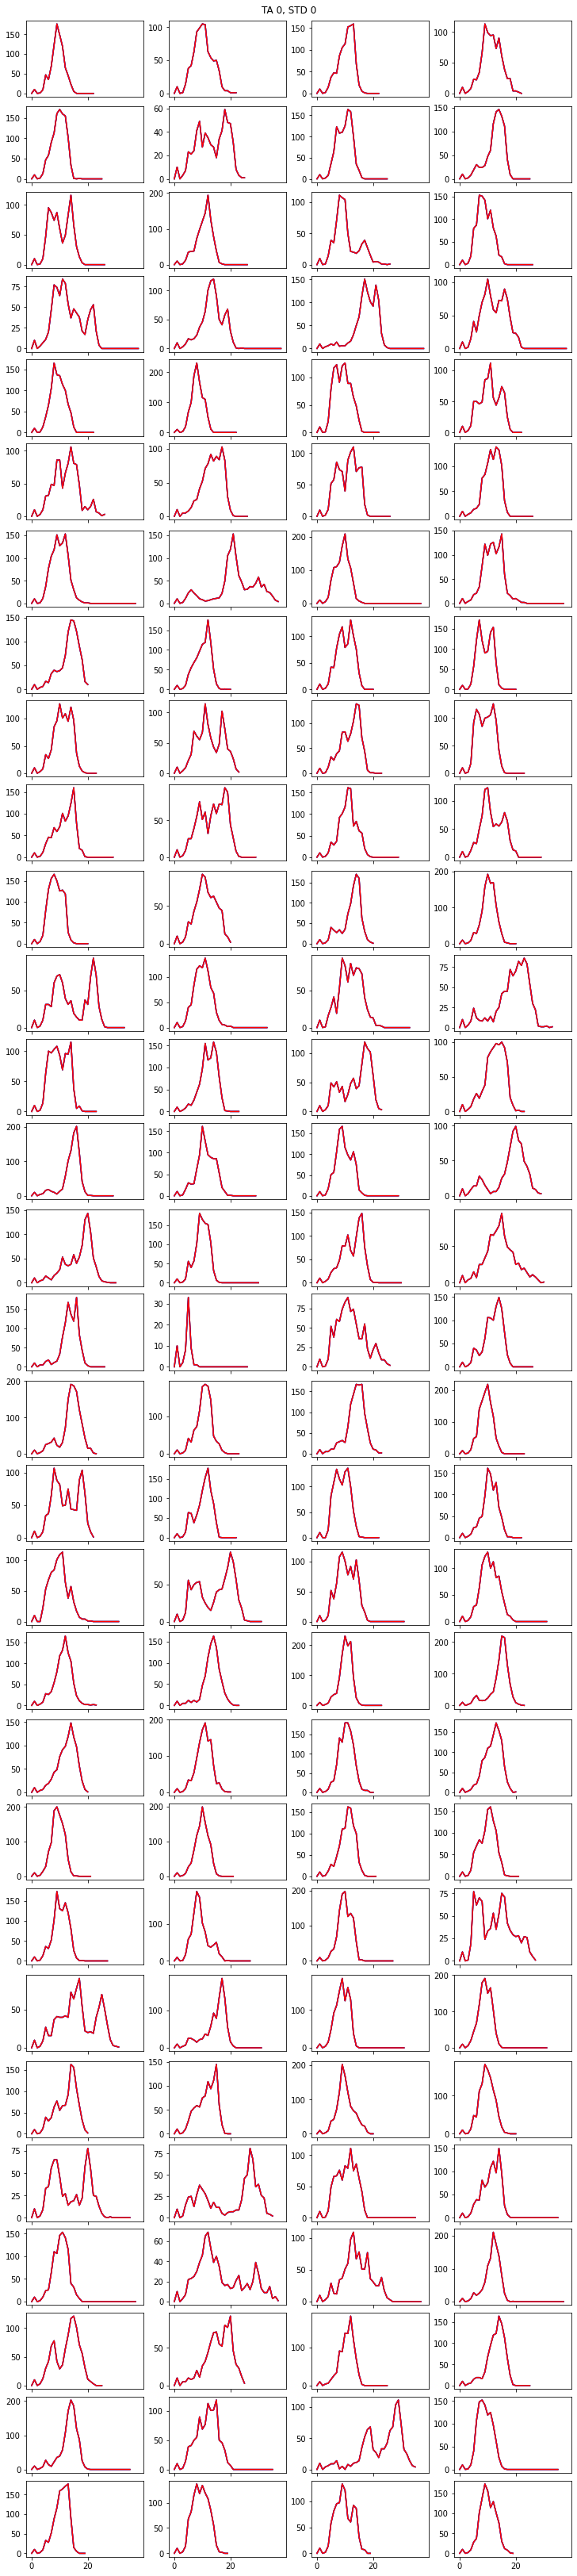

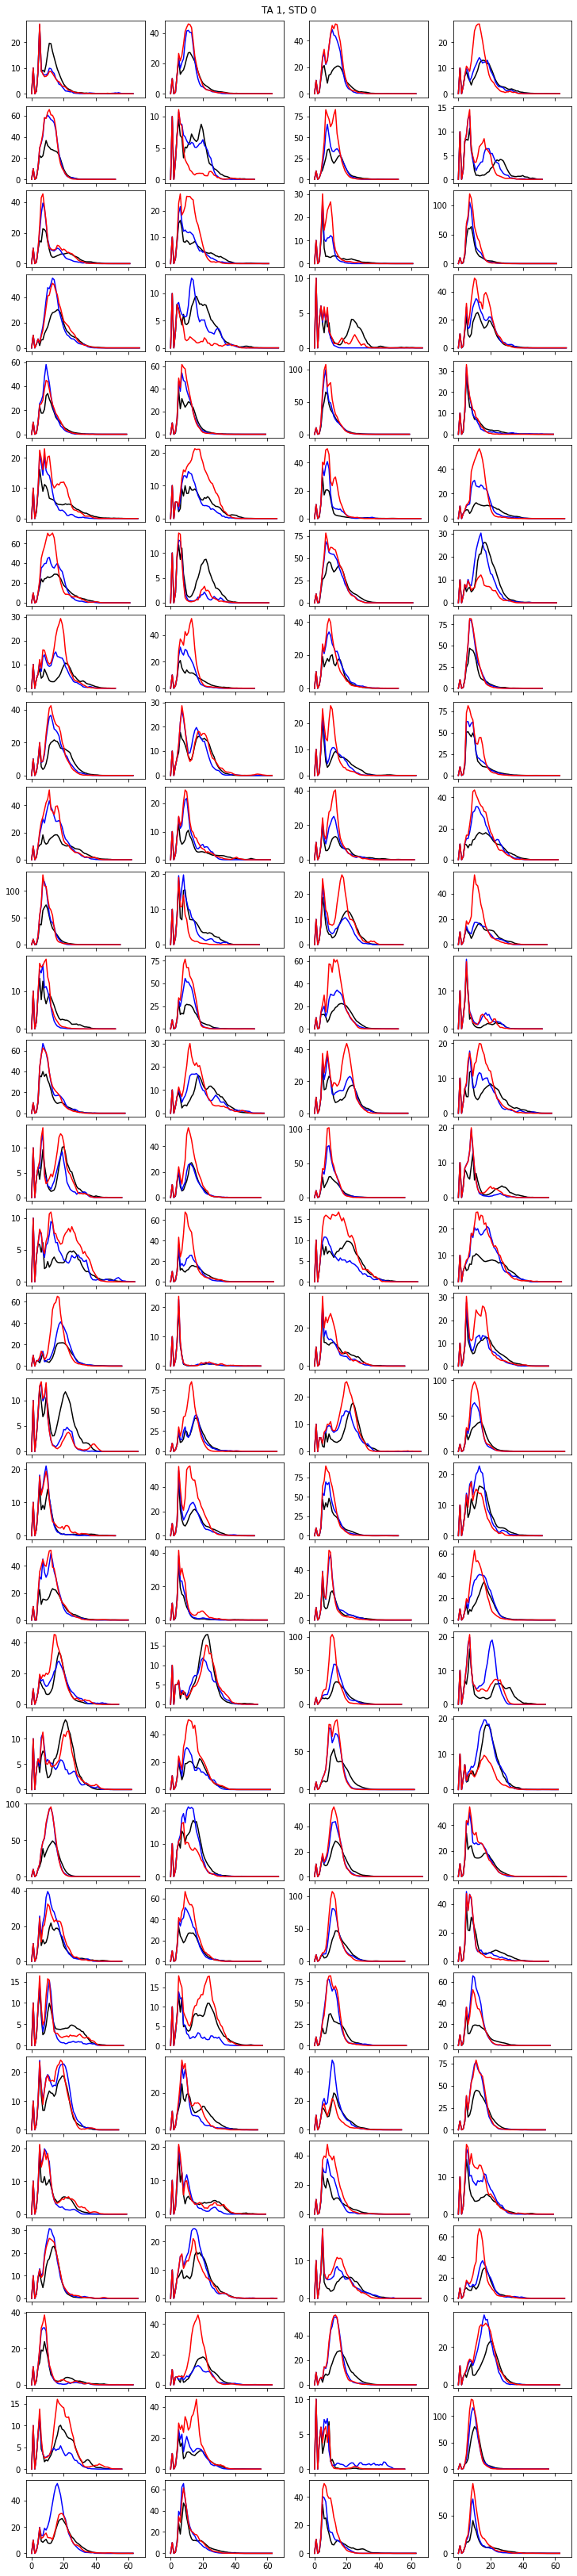

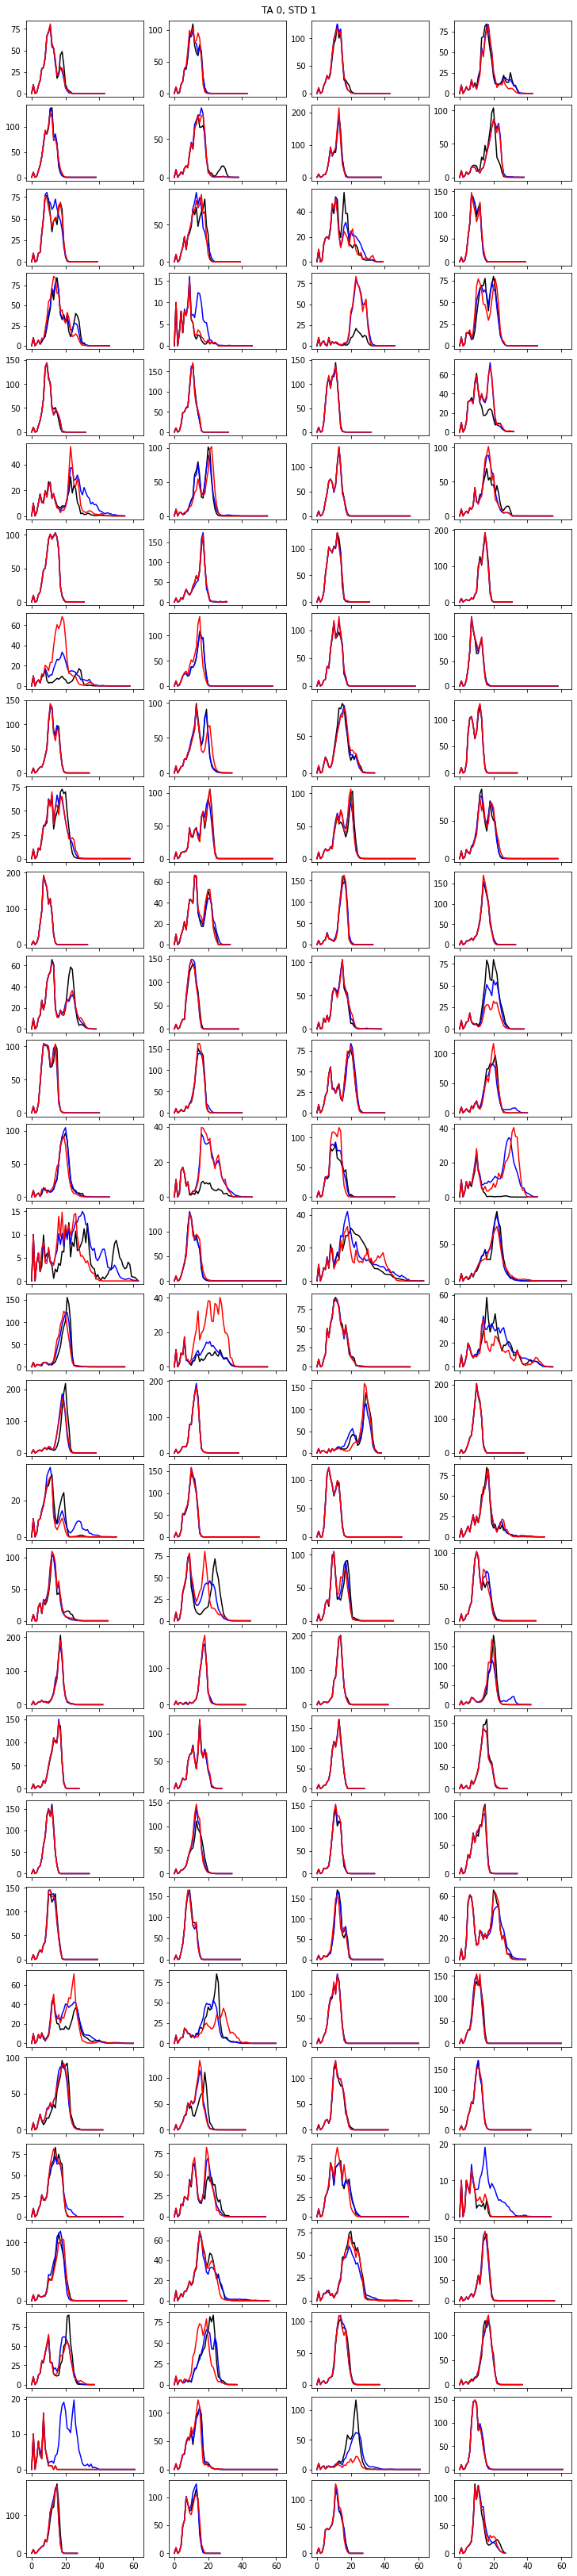

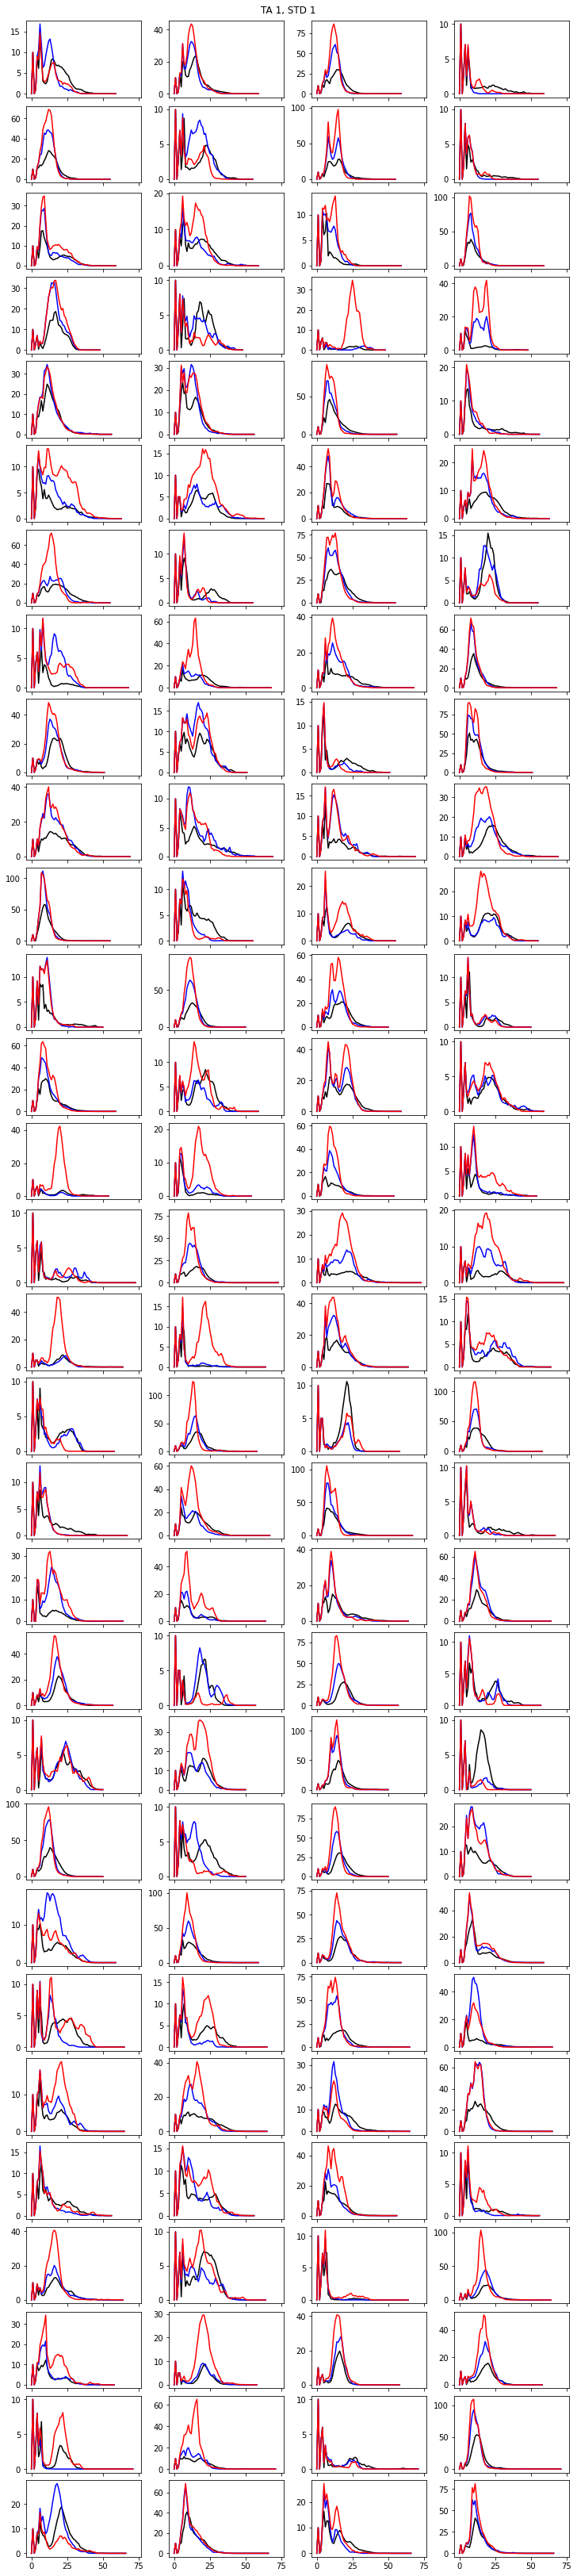

In [2]:
isi = cfg.ISIs[0]
templ = 0
nspikes = {STD: {TA: {cond: [] for cond in conds} for TA in cfg.TAs} for STD in cfg.STDs}
for STD in cfg.STDs:
    for TA in cfg.TAs:
        fig_grid, ax_grid = plt.subplots(
            cfg.N_networks, 2*len(cfg.pairings), figsize=(5*len(cfg.pairings), 1.5*cfg.N_networks),
            sharex=True, constrained_layout=True)
        fig_grid.suptitle(f'TA {TA}, STD {STD}')
        for net in range(cfg.N_networks):
            res = load_results(cfg.fname.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ), compress=True, process_dynamics=False)
            for ipair, pair in enumerate(cfg.pairings):
                for istim, stim in enumerate(pair):
                    for cond in conds:
                        data = res['spikes'][ipair][stim][cond]
                        ax_grid[net, 2*ipair+istim].plot(data['spike_hist'].sum(0), c=pu.colors[cond])
                        nspikes[STD][TA][cond].append(data['nspikes'].sum(1).mean())
        
        nspikes[STD][TA] = {cond: np.asarray(x) for cond, x in nspikes[STD][TA].items()}

In [3]:
dd.io.save('Fig5n-stats.h5', nspikes)

In [4]:
nspikes = dd.io.load('Fig5n-stats.h5')

In [5]:
def index(n0, n1):
    return ((n0-n1)/(n0+n1))

In [6]:
def label(STD, TA):
    if STD and TA:
        return 'STD+TA'
    elif STD:
        return 'STD only'
    elif TA:
        return 'TA only'
    return 'no plasticity'

In [7]:
indices = [('mismatch', 'dev', 'std'), ('adaptation', 'msc', 'std'), ('deviance detection', 'dev', 'msc')]


no plasticity
  no plasticity > 0: t= nan, p=nan
  no plasticity > 0: t= nan, p=nan
  no plasticity > 0: t= nan, p=nan

TA only
* TA only > 0: t= 9.9, p=1.26e-17
* TA only > 0: t= 6.7, p=2.997e-10
* TA only > 0: t= 5.5, p=1.011e-07

STD only
  STD only > 0: t= 1.4, p=0.07586
* STD only > 0: t= 3.2, p=0.0009829
  STD only > 0: t=-1.9, p=0.9696

STD+TA
* STD+TA > 0: t= 11, p=6.705e-21
* STD+TA > 0: t= 7.8, p=1.047e-12
* STD+TA > 0: t= 6.5, p=1.048e-09


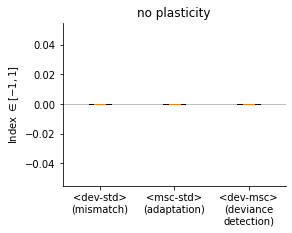

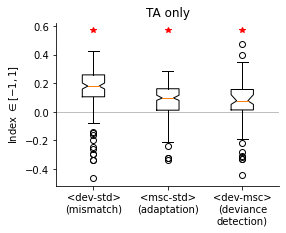

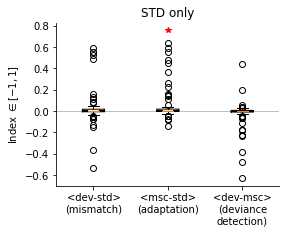

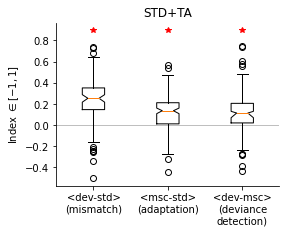

In [8]:
for STD in cfg.STDs:
    for TA in cfg.TAs:
        fig, ax = plt.subplots(figsize=(4,3))
        ax.axhline(0, color='grey', lw=1, alpha=.5)
        idx = [index(nspikes[STD][TA][i0], nspikes[STD][TA][i1]) for _, i0, i1 in indices]
        ax.boxplot(idx, notch=True, bootstrap=10000)
        newline = '\n'
        ax.set_xticks(range(1,4), [f'<{i0}-{i1}>\n({newline.join(title.split())})' for title, i0, i1 in indices])
        ax.set_ylabel('Index $\\in [-1,1]$')
        ax.set_title(label(STD, TA))

        imax = np.amax(idx)
        print(f'\n{label(STD, TA)}')
        for i, ix in enumerate(idx):
            test = stats.ttest_1samp(ix, 0, alternative='greater')
            print(f'{"*" if test.pvalue < .05 else " "} {label(STD, TA)} > 0: t={test.statistic: .2g}, p={test.pvalue:.4g}')
            if test.pvalue < .05:
                ax.plot(i+1, 1.2*imax, 'r*')
        
        sns.despine()


<dev-std>
(mismatch)
  no plasticity < STD only: t=-1.4, p=0.07586
* no plasticity < TA only: t=-9.9, p=1.26e-17
* no plasticity < STD+TA: t=-11, p=6.705e-21
* STD only < TA only: t=-6.8, p=1.834e-10
* STD only < STD+TA: t=-11, p=7.652e-20
* TA only < STD+TA: t=-5, p=9.28e-07

<msc-std>
(adaptation)
* no plasticity < STD only: t=-3.2, p=0.0009829
* no plasticity < TA only: t=-6.7, p=2.997e-10
* no plasticity < STD+TA: t=-7.8, p=1.047e-12
* STD only < TA only: t=-2.3, p=0.01114
* STD only < STD+TA: t=-4.3, p=2.112e-05
* TA only < STD+TA: t=-2.9, p=0.002028

<dev-msc>
(deviance detection)
  no plasticity < STD only: t=1.9, p=0.9696
* no plasticity < TA only: t=-5.5, p=1.011e-07
* no plasticity < STD+TA: t=-6.5, p=1.048e-09
* STD only < TA only: t=-5.7, p=4.666e-08
* STD only < STD+TA: t=-6.7, p=4.53e-10
* TA only < STD+TA: t=-3.2, p=0.001029


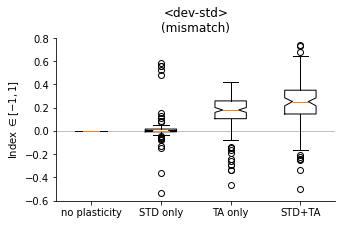

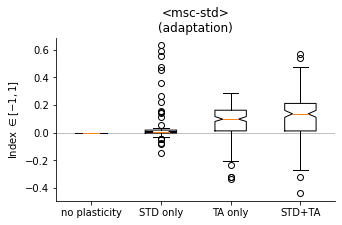

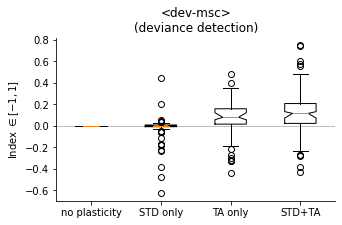

In [9]:
plasticity = [(TA, STD) for TA in cfg.TAs for STD in cfg.STDs]
for title, n0, n1 in indices:
    idx = [index(nspikes[STD][TA][n0], nspikes[STD][TA][n1]) for TA, STD in plasticity]
    fig, ax = plt.subplots(figsize=(5,3))
    ax.axhline(0, color='grey', lw=1, alpha=.5)
    ax.boxplot(idx, notch=True, bootstrap=10000)
    ax.set_xticks(range(1,5), [label(STD, TA) for TA, STD in plasticity])
    ax.set_ylabel('Index $\\in [-1,1]$')
    ax.set_title(f'<{n0}-{n1}>\n({title})')
    sns.despine()

    h = .05*np.amax(idx)
    print(f'\n<{n0}-{n1}>\n({title})')
    for i, (t0, s0) in enumerate(plasticity):
        i0 = index(nspikes[s0][t0][n0], nspikes[s0][t0][n1])
        for j, (t1, s1) in enumerate(plasticity[i+1:]):
            j += i+1
            i1 = index(nspikes[s1][t1][n0], nspikes[s1][t1][n1])
            test = stats.ttest_rel(i0, i1, alternative='less')
            print(f'{"*" if test.pvalue < .05 else " "} {label(s0,t0)} < {label(s1,t1)}: t={test.statistic:.2g}, p={test.pvalue:.4g}')

            # if test.pvalue < .05:
            #     x = (i+j)/2 + 1
            #     y = 1.3 * np.amax((i0, i1))
            #     ax.plot([i+1,i+1,j+1,j+1], [y, y+h, y+h, y], 'k-', lw=1)
            #     ax.text((i+j)/2 + 1, y+h, f'p={test.pvalue:.3g}', ha='center', va='bottom')